# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. 

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [32]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [33]:
# При необходимости добавляйте новые ячейки для кода или текста

In [34]:
# Загружаем необходимые библиотеки

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

try:
    from phik import phik_matrix
    from sqlalchemy import create_engine
    from dotenv import load_dotenv
except ImportError:
    !pip install phik
    !pip install sqlalchemy
    !pip install psycopg2-binary
    !pip install python-dotenv==1.2.1
    from phik import phik_matrix
    from sqlalchemy import create_engine
    from dotenv import load_dotenv

load_dotenv();

In [35]:
# Создаём строку подключения и движок

if os.getenv('user'):
    connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
        os.getenv('user'),
        os.getenv('pwd'),
        os.getenv('host'),
        os.getenv('port'),
        os.getenv('db'),
    )
else:
    db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

    connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
        db_config['user'],
        db_config['pwd'],
        db_config['host'],
        db_config['port'],
        db_config['db'],
    )
engine = create_engine(connection_string)

In [36]:
# Импортируем необходимые данные из базы данных и формируем рабочий датафрейм
query = '''
  SELECT
    p.user_id
    , p.device_type_canonical
    , p.order_id
    , p.created_dt_msk AS order_dt
    , p.created_ts_msk AS order_ts
    , p.currency_code
    , p.revenue
    , p.tickets_count
    , date_part('day', p.created_dt_msk - (
        LAG(p.created_dt_msk) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)
      )) as days_since_prev
    , p.event_id
    , e.event_name_code event_name
    , e.event_type_main
    , p.service_name
    , r.region_name
    , c.city_name
  FROM afisha.purchases p
  LEFT JOIN afisha.events e USING(event_id) 
  LEFT JOIN afisha.city c USING(city_id)
  LEFT JOIN afisha.regions r USING(region_id)
  WHERE
    ((p.device_type_canonical = 'mobile')
    OR (p.device_type_canonical = 'desktop'))
    AND (e.event_type_main != 'фильм')
  ORDER BY user_id;
'''
df = pd.read_sql_query(query, con=engine)

In [37]:
# Создаём копию первичного датафрейма для последующего анализа изменений в данных
df_primary = df.copy()

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Выведем информацию о структуре данных и пример самих данных. 

In [38]:
print('Информация о датафрейме:')
print(df.info())
print('----------------------------')
print('Пример строк нескольких случайных строк данных:')
df.sample(5)

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name       

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
219246,b56c1232e4bdae4,mobile,1766652,2024-10-08,2024-10-08 12:13:35,rub,5.32,1,0.0,441519,8dd46740-a09f-46c4-9ea1-326472003fc8,другое,Лови билет!,Зоринский регион,Луговинск
225875,bf489c49636f34b,desktop,6842493,2024-10-21,2024-10-21 07:57:33,rub,442.93,5,2.0,96215,c6b23415-3032-4b72-8bdb-bd60a07d7930,театр,Тебе билет!,Зоринский регион,Луговинск
45327,1c2a2133e1df1b4,mobile,7932400,2024-07-12,2024-07-12 23:42:49,rub,1.35,1,0.0,543075,bd95a4cb-ffdc-474d-8791-87c3203d8646,другое,Мой билет,Широковская область,Травянский
248150,d54a70442b39259,mobile,4767485,2024-10-13,2024-10-13 14:35:31,rub,34.06,3,1.0,563075,eaab3860-ceb4-4b9e-a0cf-0b5c8ea9eca9,другое,Билеты без проблем,Каменевский регион,Глиногорск
230956,c62604ad2f72d0c,mobile,6823846,2024-08-19,2024-08-19 16:17:13,rub,1816.00,2,2.0,547262,dfc906ae-d3fb-489d-9d84-5f3ce2ad7c44,концерты,Билеты без проблем,Каменевский регион,Глиногорск


В датафрейм хорошо импортировались данные формата даты-времени. Исходя из логики входных данных, хочется привести `days_since_prev` к целочисленному виду. `device_type_canonical`, `currency_code`, `event_type_main`, `service_name`, `city_name`, `region_name` на первый взгляд, стои привести к категориальному типу данных. Оставшимся числовым данным стоит понизить разрядность.

Оценим количество и долю пропусков в данных

In [39]:
gaps = pd.DataFrame()
gaps['gaps_count'] = df.isna().sum()
gaps['gaps_share'] = round(gaps['gaps_count'] / df.shape[0], 3)
gaps

,gaps_count,gaps_share
user_id,0,0.000
device_type_canonical,0,0.000
order_id,0,0.000
order_dt,0,0.000
order_ts,0,0.000
currency_code,0,0.000
revenue,0,0.000
tickets_count,0,0.000
days_since_prev,21933,0.075
event_id,0,0.000


Пропуски содержатся в одном поле, сформированном нами при выгрузке. Условием выгрузки было оставить NaN при условии, что это был первый заказ у пользователя.

При этом, в ходе анализа возможных значений поля `days_since_prev` было выявлено преобладающее количество нулевых значений:

In [77]:
def count_percent_value(df_local, column, head=10):
    temp_df = pd.DataFrame({
        'Количество': df_local[column].value_counts(),
        'Процент' : df_local[column].value_counts() * 100 / df_local.shape[0]
    }).head(head)
    display(temp_df.style.format({'Процент': '{:.2f}'}).background_gradient(cmap='coolwarm'))

count_percent_value(df, 'days_since_prev')

,Количество,Процент
0,183806,63.33
1,30431,10.49
2,9933,3.42
3,6177,2.13
4,4404,1.52
5,3399,1.17
6,2721,0.94
7,2400,0.83
8,1842,0.63
9,1632,0.56


В целом, данные импортировались хорошо. Пропуски появились контролируемо - в ходе выгрузки и мы можем их анализировать исходя из их известной природы, заменяя на маркер (например `-1`) или оставляя в исходном виде. Есть поля, над которыми стоит произвести операции преобразования типов. Стоит изучить большое количество нулевых значений в поле количества дней со ня предыдущего заказа.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Добавим столбец со значением выручки в одной валюте - российских рублях

In [41]:
# Импортируем данные о курсах казахских тенге
tenge_rub_rates_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
tenge_rub_rates_df['data'] = pd.to_datetime(tenge_rub_rates_df['data'])
tenge_rub_rates = tenge_rub_rates_df.set_index('data')['curs'] # Создаём серию с датами в качестве индексов
df['revenue_rub'] = df['revenue'].where( # Добавляем столбец с суммой выручки в рублях
    df['currency_code'] == 'rub',  # Если валюта rub — оставляем как есть
    round(df['revenue'] * df['order_dt'].map(tenge_rub_rates) / 100, 2)  # Иначе — умножаем на курс
)

Пример строчек с валютой `kzt`:

In [42]:
df[df['currency_code'] == 'kzt'].sample(2)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
199843,a6cc488882fdee8,desktop,7995881,2024-06-06,2024-06-06 13:12:17,kzt,5548.24,3,NaN,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1099.02
255320,dec9ca471da062a,mobile,50983,2024-06-05,2024-06-05 20:58:52,kzt,5548.24,3,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1101.48


Пример строчек с валютой `rub`:

In [43]:
df[df['currency_code'] == 'rub'].sample(2)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
278941,f6c8dc842b31271,mobile,3444795,2024-10-26,2024-10-26 13:35:19,rub,498.57,5,9.0,561501,77ed1138-ff00-48ca-819e-1430f79af1fd,театр,Билеты в руки,Каменевский регион,Глиногорск,498.57
72859,340ca747571cd45,mobile,8485662,2024-09-08,2024-09-08 00:19:13,rub,1577.80,4,6.0,317299,a00e1032-6463-4fdc-a105-fdbb6789b556,театр,Край билетов,Каменевский регион,Глиногорск,1577.80


Столбец со стоимостью, приведенный к рублям сформировался корректно.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Данные с датой и временем импортированы корректно. Столбцы `order_dt` и `order_ts` имеют тип данных `datetime64[ns]`.

Преобразуем данные в соответствии с указанными выше рекомендациями: Исходя из логики входных данных, хочется привести `days_since_prev` к целочисленному виду

In [44]:
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], errors='coerce').round(0).astype('Int32')

In [45]:
df['days_since_prev'].dtype

Int32Dtype()

Требуемый тип данных нужной разрядности получен

Приведём `device_type_canonical`, `currency_code`, `event_type_main`, `service_name`, `city_name`, `region_name` к категориальному типу данных, с предварительной оценкой неоходимости такого действия.

In [46]:
def should_convert_to_category(series, threshold=0.5): # Проверяет необходимость конвертации. Если категорий меньше 50% строк - стоит.
    if series.dtype != 'object':
        return False
    unique_ratio = series.nunique() / len(series)
    return unique_ratio < threshold, series.nunique(), unique_ratio 
candidates = ['device_type_canonical', 'currency_code', 'event_type_main', 'service_name', 'city_name', 'region_name']
for candidate in candidates:
    should_convert, unique, ratio = should_convert_to_category(df[candidate])
    if should_convert:
        print(f'Столбец {candidate} стоит перевести в тип category. Уникальных значений: {unique}, их доля: {ratio}.')
    else:
        print(f'Столбецу {candidate} не стоит менять тип данных. Уникальных значений: {unique}, их доля: {ratio}.')


Столбец device_type_canonical стоит перевести в тип category. Уникальных значений: 2, их доля: 6.882051952610191e-06.
Столбец currency_code стоит перевести в тип category. Уникальных значений: 2, их доля: 6.882051952610191e-06.
Столбец event_type_main стоит перевести в тип category. Уникальных значений: 7, их доля: 2.4087181834135665e-05.
Столбец service_name стоит перевести в тип category. Уникальных значений: 36, их доля: 0.00012387693514698343.
Столбец city_name стоит перевести в тип category. Уникальных значений: 352, их доля: 0.0012112411436593935.
Столбец region_name стоит перевести в тип category. Уникальных значений: 81, их доля: 0.0002787231040807127.


Все указанные столбцы имеют небольшое отношение уникальных значений к общему числу строк. Перевод имеет смысл.

Визуально осмотрим потенциально категориальные данные, за исключением больших категорий названий городов и регионов на наличие значений, символизирующих пропуск или другое подобное значение

In [47]:
for c in candidates:
    if c not in ['city_name', 'region_name']:
        print(c)
        print(list(df[c].unique()))

device_type_canonical
['mobile', 'desktop']
currency_code
['rub', 'kzt']
event_type_main
['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']
service_name
['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!', 'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная', 'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки', 'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко', 'Билет по телефону', 'Выступления.ру', 'Росбилет', 'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет', 'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ', 'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет', 'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете']


В категории `event_type_main` обнаружена категория `другое`, которая является некоторым неопределенным значением, но которое не является в строгом смысле пропуском, поскольку отрицает все иные, явно обозначенные категории.

Проверим категориальные данные на уникальность при нормализации:

In [48]:
for c in candidates:   
    s = df[c].str.upper().str.strip()
    non_unique_count = df[c].nunique() - s.nunique()
    print(f'В столбце {c} содержится {non_unique_count} категорий с повторами при нормализации строк.')
    df[c] = df[c].str.strip() # Уберём в столбце датафрейма вохможные начальные и конечные пробелы

В столбце device_type_canonical содержится 0 категорий с повторами при нормализации строк.
В столбце currency_code содержится 0 категорий с повторами при нормализации строк.
В столбце event_type_main содержится 0 категорий с повторами при нормализации строк.
В столбце service_name содержится 0 категорий с повторами при нормализации строк.
В столбце city_name содержится 0 категорий с повторами при нормализации строк.
В столбце region_name содержится 0 категорий с повторами при нормализации строк.


Повторяющихся данных при нормализации потенциально категориальных данных не обнаружено. Мы считаем, что нормализовать данные переводом в верхний регистр для анализа в указанных столбцах нецелесообразно. Названия регионов и городов с заглавной буквы вполне естественны. Названия сервисов можно было бы нормализовать, но некоторые сервисы имеют визуальное разделение строчных и заглавных букв (например `КарандашРУ`) и при нормализации такое разделение сотрётся. Начальные и конечные пробелы в будущих категориальных стобцах убраны.

Преобразуем тип данных

In [49]:
for c in candidates:
    df[c] = df[c].astype('category')
    print(f'Тип данных столбца {c}: {df[c].dtype}')

Тип данных столбца device_type_canonical: category
Тип данных столбца currency_code: category
Тип данных столбца event_type_main: category
Тип данных столбца service_name: category
Тип данных столбца city_name: category
Тип данных столбца region_name: category


Уменьшим разрядность целочисленных столбцов. Сначала проверим границы их значений:

In [50]:
info32 = np.iinfo(np.int32)
min_int32 = info32.min
max_int32 = info32.max
for column in df.columns:
    if df[column].dtype == 'int64':
        if (df[column].max() <= max_int32) and (df[column].min() >= min_int32):
            df[column] = df[column].astype('int32')

Теперь уменьшим разрядность столбцов с типом данных `float64`:

In [51]:
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = pd.to_numeric(df[column], errors='coerce', downcast = 'float')
        print(f'Столбец {column} теперь имеет тип данных {df[column].dtype}')

Столбец revenue теперь имеет тип данных float32
Столбец revenue_rub теперь имеет тип данных float32


Изучим статистические показатели числовых данных

In [52]:
num_cols = []
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        num_cols.append(column)
        print(f'Столбец {column} - числовой. Тип данных - {df[column].dtype}')

Столбец order_id - числовой. Тип данных - int32
Столбец revenue - числовой. Тип данных - float32
Столбец tickets_count - числовой. Тип данных - int32
Столбец days_since_prev - числовой. Тип данных - Int32
Столбец event_id - числовой. Тип данных - int32
Столбец revenue_rub - числовой. Тип данных - float32


Исключим из исследования идентификационные столбцы `order_id`, `event_id`, а также нерепрезентативный без обозначения валюты столбец `revenue` и выведем статистики оставшихся числовых столбцов

In [53]:
num_cols = [x for x in num_cols if x not in ['order_id', 'revenue', 'event_id']]
df[num_cols].describe()

,tickets_count,days_since_prev,revenue_rub
count,290611.000000,268678.000000,290611.000000
mean,2.754311,3.222381,555.572083
std,1.170620,11.350509,875.498169
min,1.000000,0.000000,-90.760002
25%,2.000000,0.000000,113.970001
50%,3.000000,0.000000,351.140015
75%,4.000000,1.000000,802.049988
max,57.000000,148.000000,81174.539062


Видим выбросы и по выручке, и по количеству билетов и в днях между заказами. При анализе можно отфильтровать выбросы в поле дней между заказами. С остальными выбросами надо разобраться. Кроме того, присутствует аномалия в виде отрицательной стоимости заказа. Выведем примеры заказов с отрицательной стоимостью и некоторые данные по ним

In [54]:
negative_rev = df[df['revenue_rub'] < 0]
display(negative_rev.sample(3))
print(f'Количество заказов с отрицательной стоимостью: {negative_rev.shape[0]}')
print(f'Доля заказов с отрицательной стоимостью: {negative_rev.shape[0] / df.shape[0]}')
print(f'Общая сумма заказов с отрицательной стоимостью: {negative_rev["revenue_rub"].sum()}')
print(f'Уникальных пользователей у заказов с отрицательной стоимостью: {negative_rev["user_id"].nunique()}')
print(f'Уникальных билетных операторов у заказов с отрицательной стоимостью: {negative_rev["service_name"].nunique()}')
print(f'Первых заказов, среди заказов с отрицательной стоимостью: {negative_rev["days_since_prev"].isna().sum()}')

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
174576,8d8d256ddcb72ff,desktop,3927065,2024-06-24,2024-06-24 16:07:54,rub,-2.37,3,8,538650,ffe03bc6-0e0c-480d-b037-6a4b55540ab5,другое,Билеты без проблем,Берёзовская область,Златопольск,-2.37
157206,803cadfe19883a9,mobile,8197344,2024-09-28,2024-09-28 21:11:03,rub,-3.59,1,58,568916,b1a3919a-5d3e-4da2-b6f5-eccb480d810c,другое,Билеты в руки,Малиновая область,Зеленополье,-3.59
37789,18e9aead0a393e7,mobile,1226324,2024-06-26,2024-06-26 05:51:50,rub,-0.44,2,0,538635,cd59ca06-c661-484b-b141-9eb5e5ea19cf,другое,Билеты без проблем,Берёзовская область,Златопольск,-0.44


Количество заказов с отрицательной стоимостью: 381
Доля заказов с отрицательной стоимостью: 0.0013110308969722412
Общая сумма заказов с отрицательной стоимостью: -949.5899658203125
Уникальных пользователей у заказов с отрицательной стоимостью: 175
Уникальных билетных операторов у заказов с отрицательной стоимостью: 5
Первых заказов, среди заказов с отрицательной стоимостью: 36


Происхождение заказов с отрицательной стоимостью непонятно. Это либо скидка либо ошибка в данных. С одной стороны, доля таких строк небольшая, как и общая сумма выручки от этих заказов и для дальнейшего исследования данных можно удалить данные строки. С другой, они встречаются у разных операторов и не по одному разу у некоторых пользователей. Возможно, будет отслежена некоторая закономерность. Можно, также, отфильтровать отрицательные значения при подсчёте статистик выручки от заказов.

Посмотрим на общее число заказов пользователей с отрицательными стоимостями заказов. Выделим топ 10 таких пользователей и посмотрим на распределение заказов по этим пользователям вцелом по всем заказам и по заказам с отрицательной стоимостью для решения вопроса о судьбе этих строк.

In [55]:
temp = pd.DataFrame()
users = negative_rev['user_id'].unique().tolist()
temp['orders_total'] = df[df['user_id'].isin(users)]['user_id'].value_counts()
temp['percent_in_tot'] = (temp['orders_total'] / df.shape[0] * 100).round(3)
temp['cumulative_pct_tot']=temp['percent_in_tot'].cumsum()
temp['neg_orders'] = negative_rev['user_id'].value_counts()
temp['percent_in_neg'] = (temp['neg_orders'] / negative_rev.shape[0] * 100).round(3)
temp['cumulative_pct_neg']=temp['percent_in_neg'].cumsum()

temp.head(10)

,orders_total,percent_in_tot,cumulative_pct_tot,neg_orders,percent_in_neg,cumulative_pct_neg
0beb8fc0c0a9ce1,10251,3.527,3.527,13,3.412,3.412
18e9aead0a393e7,4368,1.503,5.030,5,1.312,4.724
8187dac4be757a0,4053,1.395,6.425,7,1.837,6.561
3ee7dc2e115847f,3826,1.317,7.742,5,1.312,7.873
1c2a2133e1df1b4,3538,1.217,8.959,1,0.262,8.135
ad2dc32364ed948,3275,1.127,10.086,1,0.262,8.397
b54dd0cd81121fc,3163,1.088,11.174,10,2.625,11.022
cdbc02c6ad8087a,3071,1.057,12.231,4,1.050,12.072
02ea4583333f064,3006,1.034,13.265,2,0.525,12.597
8d6c1ff89fac35f,2880,0.991,14.256,1,0.262,12.859


Мы видим, что отрицательные суммы заказов появлялись у 10 пользователей осуществивших 14.26% от общего числа заказов. Одновременно мы наблюдаем пропорциональное распределение числа заказов и среди заказов с отрицательной стоимостью между этими десятью пользователями. На основании того, что отрицательная сумма заказа появлялась у пользователей, впервые оформивших заказ, отвергаем предположение о скидке к предыдущим заказам. На основании равномерного распределения отрицательных стоимостей заказа среди пользователей, совершивших больше всего заказов, делаем вывод о достаточно равномерно распределенных ошибках в виде этих отрицательных стоимостей и, ввиду небольшой доли таких записей (0.13% от всех записей) принимаем решение их удалить.

In [56]:
rows_old = df.shape[0]
df = df[df['revenue_rub'] >= 0]
rows_new = df.shape[0]
print(f'Удалено записей: {rows_old - rows_new}.')

Удалено записей: 381.


Далее визуализируем числовые столбцы диаграммами размаха:

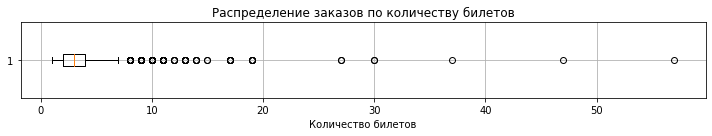

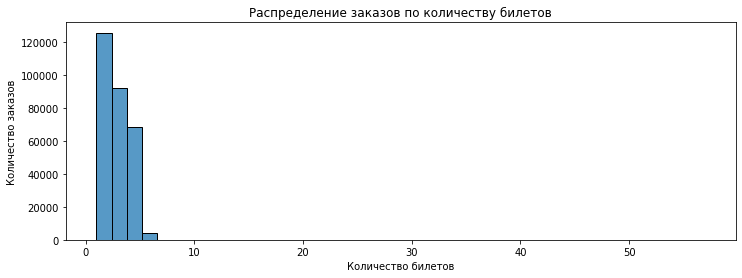

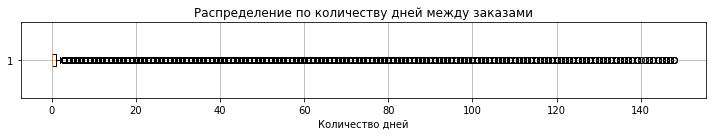

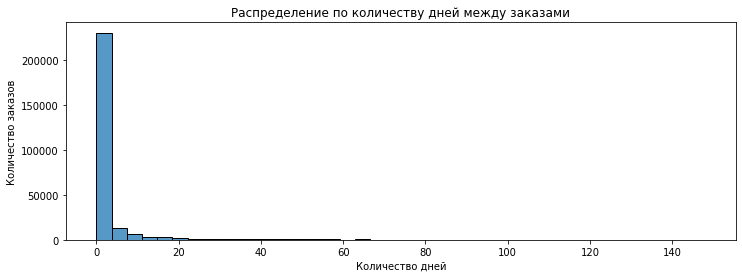

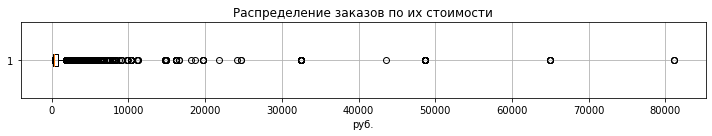

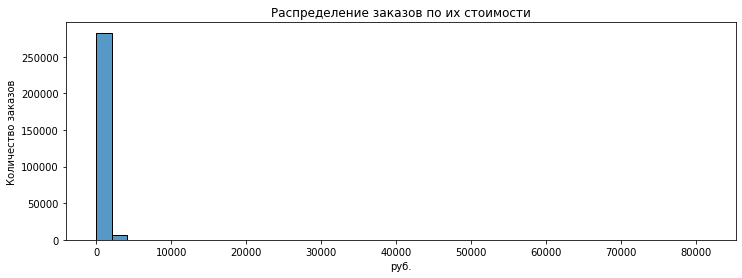

In [57]:
def boxplot(df, figsize=(10,2), vert=False, showfliers=True, xlabel='Ось Х', title='Заголовок', grid=True):
    data = df.dropna() if isinstance(df, pd.Series) else df.dropna(axis=0)
    plt.figure(figsize=figsize)
    plt.boxplot(
        data,
        vert=vert,
        showfliers=showfliers
    )
    plt.xlabel(xlabel)
    plt.grid(grid)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def histplot(df, figsize=(12, 4), showfliers=True, x=None, bins=40, xlabel='Ось X', ylabel='Ось Y', title='Заголовок'):
    plt.figure(figsize=figsize)
    if not showfliers:
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df >= lower_bound) & (df <= upper_bound)]

    sns.histplot(
        data=df,
        x=x,
        bins=bins,
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

cols = [['tickets_count', 'Количество билетов', 'Распределение заказов по количеству билетов'],
        ['days_since_prev', 'Количество дней', 'Распределение по количеству дней между заказами'],
        ['revenue_rub', 'руб.', 'Распределение заказов по их стоимости']]
for col in cols:
    boxplot(df[col[0]], xlabel=col[1], title=col[2])
    histplot(df[col[0]], xlabel=col[1], title=col[2], ylabel='Количество заказов')

Те же диаграммы без выбросов

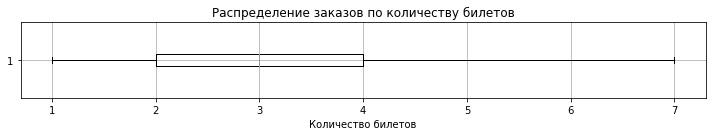

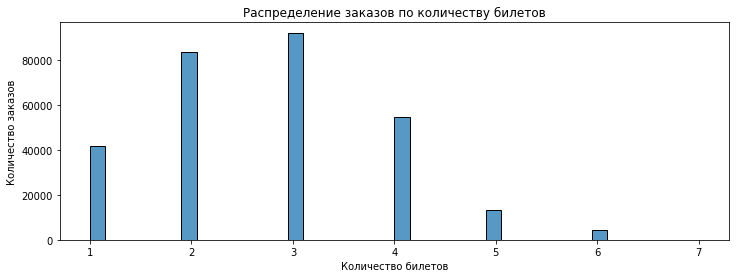

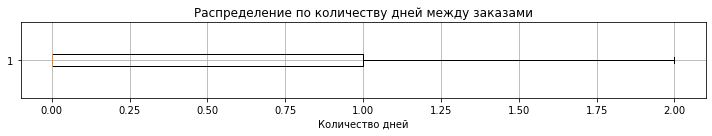

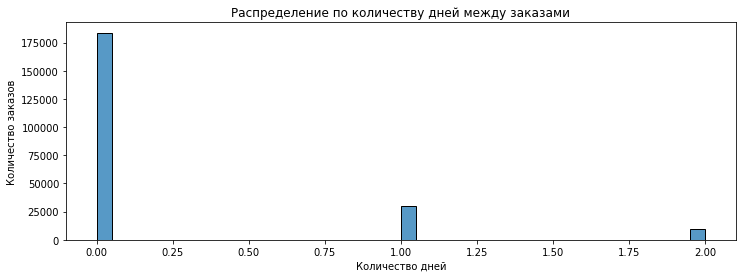

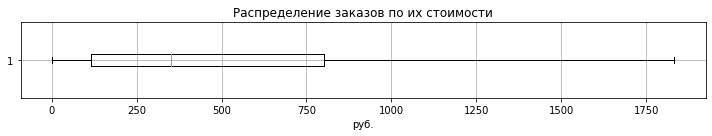

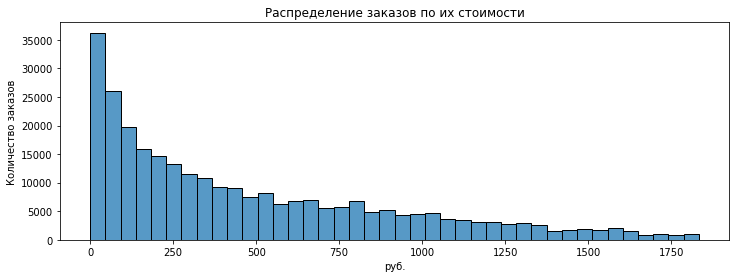

In [58]:
for col in cols:
    boxplot(df[col[0]], xlabel=col[1], title=col[2], showfliers=False)
    histplot(df[col[0]], xlabel=col[1], title=col[2], ylabel='Количество заказов', showfliers=False)

Результаты осуществленной предобработки можно визуализировать таблицей:

In [59]:
def compare_dfs_side_by_side(df1, df2, name1="Исходный", name2="Обработанный"):
    all_cols = df1.columns.union(df2.columns, sort=False)
    report = []

    for col in all_cols:
        # Проверяем, есть ли столбец в каждом датафрейме
        in_df1 = col in df1.columns
        in_df2 = col in df2.columns

        if in_df1 and in_df2:
            # Столбец есть в обоих — сравниваем тип и количество
            dtype1 = df1[col].dtype
            dtype2 = df2[col].dtype
            count1 = df1[col].count()
            count2 = df2[col].count()
            delta = count2 - count1
            if dtype1 == dtype2 and delta == 0:
                status = 'Без изменений'
            else:
                status = 'Изменён'
        elif in_df1:
            # Столбец удалён
            dtype1 = df1[col].dtype
            dtype2 = "—"
            count1 = df1[col].count()
            count2 = 0
            delta = -count1
            status = 'Удалён'
        else:  # in_df2 only
            # Столбец добавлен
            dtype1 = "—"
            dtype2 = df2[col].dtype
            count1 = 0
            count2 = df2[col].count()
            delta = count2
            status = 'Добавлен'

        report.append({
            'column': col,
            'status': status,
            f'dtype_{name1}': dtype1,
            f'dtype_{name2}': dtype2,
            f'count_{name1}': count1,
            f'count_{name2}': count2,
            'count_change': delta
        })

    return pd.DataFrame(report).set_index('column')


display(compare_dfs_side_by_side(df_primary, df))


,status,dtype_Исходный,dtype_Обработанный,count_Исходный,count_Обработанный,count_change
column,,,,,,
user_id,Изменён,object,object,290611,290230,-381
device_type_canonical,Изменён,object,category,290611,290230,-381
order_id,Изменён,int64,int32,290611,290230,-381
order_dt,Изменён,datetime64[ns],datetime64[ns],290611,290230,-381
order_ts,Изменён,datetime64[ns],datetime64[ns],290611,290230,-381
currency_code,Изменён,object,category,290611,290230,-381
revenue,Изменён,float64,float32,290611,290230,-381
tickets_count,Изменён,int64,int32,290611,290230,-381
days_since_prev,Изменён,float64,Int32,268678,268333,-345


В результате преобразований, добавлен один столбец, изменены предполагаемые категориальные типы данных, целочисленный по смыслу столбец приведён к целочисленному типу данных с понижением разрадности, также разрядность понижена у всех остальных числовых столбцов. Количество данных не изменено, пропуски оставлены, как безопасные для анализа. Обнаружены аномалии в стоимости заказов - заказы с отрицательной стоимостью. В результате предварительного анализа этих аномалий, логического объяснения их наличия не найдено, как и рациональной причины для их сохранения. Удалено 381 строк.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


Получим датафрейм профилей пользователей

In [60]:
df_sorted = df.sort_values(by='order_ts', ascending=True)

In [61]:
def calculate_avg_interval(group):
    if len(group) <= 1:
        return np.nan

    first_ts = group['order_ts'].min()
    last_ts = group['order_ts'].max()
    num_orders = len(group)
    
    avg_interval = (last_ts - first_ts) / (num_orders - 1)
    return avg_interval

df_profiles = (df_sorted
              .groupby('user_id')
              .agg({
                  'order_dt': ['first', 'last'],
                  'device_type_canonical': 'first',
                  'region_name': 'first',
                  'service_name' : 'first',
                  'event_type_main': 'first',
                  'order_id': 'count',
                  'revenue_rub': 'mean',
                  'tickets_count': 'mean',
              })
)
df_profiles.columns = [
    'order_dt_first', 'order_dt_last',
    'device_first_order', 'region_first_order',
    'service_name_first', 'event_type_first',
    'orders_count', 'revenue_rub_mean',
    'mean_tickets_in_order',
]

avg_intervals = (
    df_sorted.groupby('user_id').apply(calculate_avg_interval)
    .rename('avg_order_interval')
    .reset_index()
)
df_profiles = df_profiles.merge(avg_intervals, on='user_id', how='left')
df_profiles['is_two'] = (df_profiles['orders_count'] >= 2)
df_profiles['is_five'] = (df_profiles['orders_count'] >= 5)
display(df_profiles.info())
df_profiles.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21917 entries, 0 to 21916
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                21917 non-null  object         
 1   order_dt_first         21917 non-null  datetime64[ns] 
 2   order_dt_last          21917 non-null  datetime64[ns] 
 3   device_first_order     21917 non-null  object         
 4   region_first_order     21917 non-null  object         
 5   service_name_first     21917 non-null  object         
 6   event_type_first       21917 non-null  object         
 7   orders_count           21917 non-null  int64          
 8   revenue_rub_mean       21917 non-null  float32        
 9   mean_tickets_in_order  21917 non-null  float64        
 10  avg_order_interval     13548 non-null  timedelta64[ns]
 11  is_two                 21917 non-null  bool           
 12  is_five                21917 non-null  bool   

None

,user_id,order_dt_first,order_dt_last,device_first_order,region_first_order,service_name_first,event_type_first,orders_count,revenue_rub_mean,mean_tickets_in_order,avg_order_interval,is_two,is_five
19475,e2c59ab6c9b7ef9,2024-10-15,2024-10-31,mobile,Каменевский регион,Облачко,театр,4,352.932495,2.750000,5 days 11:51:01.666666666,True,False
920,0b3670be29d754f,2024-10-02,2024-10-02,desktop,Североярская область,Лучшие билеты,спорт,1,83.290001,3.000000,NaT,False,False
18368,d5d50c8d9a01d50,2024-09-11,2024-09-11,desktop,Широковская область,Мой билет,стендап,3,2232.653320,3.666667,0 days 00:04:31,True,False


Преобразуем типы данных в столбцах: 
- преобразовав тип `object` в категориальный тип, если число уникальных значений составляет менее половины общего количества строк;
- понизив разрядность для типа `int64`;
- понизив разрядность и округлив `float64` и просто округлив `float32`.

In [62]:
for column in df_profiles.columns:
    if df_profiles[column].dtype == 'int64':
        if (df_profiles[column].max() <= max_int32) and (df_profiles[column].min() >= min_int32):
            df_profiles[column] = df_profiles[column].astype('int32')
    elif df_profiles[column].dtype == 'object':
        should_convert, unique, ratio = should_convert_to_category(df_profiles[column])
        if should_convert:
            df_profiles[column] = df_profiles[column].astype('category')
    elif df_profiles[column].dtype == np.float32:
        df_profiles[column] = df_profiles[column].astype(np.float64).round(2)
    if df_profiles[column].dtype == 'float64':
        df_profiles[column] = pd.to_numeric(df_profiles[column].round(2), errors='coerce', downcast = 'float')

display(df_profiles.info())
df_profiles.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21917 entries, 0 to 21916
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                21917 non-null  object         
 1   order_dt_first         21917 non-null  datetime64[ns] 
 2   order_dt_last          21917 non-null  datetime64[ns] 
 3   device_first_order     21917 non-null  category       
 4   region_first_order     21917 non-null  category       
 5   service_name_first     21917 non-null  category       
 6   event_type_first       21917 non-null  category       
 7   orders_count           21917 non-null  int32          
 8   revenue_rub_mean       21917 non-null  float32        
 9   mean_tickets_in_order  21917 non-null  float32        
 10  avg_order_interval     13548 non-null  timedelta64[ns]
 11  is_two                 21917 non-null  bool           
 12  is_five                21917 non-null  bool   

None

,user_id,order_dt_first,order_dt_last,device_first_order,region_first_order,service_name_first,event_type_first,orders_count,revenue_rub_mean,mean_tickets_in_order,avg_order_interval,is_two,is_five
327,03fc374cf3fe17f,2024-09-24,2024-09-24,mobile,Луговая область,Облачко,концерты,2,608.919983,2.5,0 days 00:11:02,True,False
597,0753a2370733d58,2024-09-17,2024-09-17,desktop,Широковская область,Мой билет,театр,1,78.150002,1.0,NaT,False,False
21143,f6f80da0d654a88,2024-10-22,2024-10-22,mobile,Малиновая область,Билеты в руки,театр,1,398.200012,3.0,NaT,False,False


К сожалению, округление или двойное преобразование с округлением значения столбца `revenue_rub_mean` показывает некорректное значение при использовании формата `float32`. Преобразуем его явно в `float64`

In [63]:
df_profiles['revenue_rub_mean'] = df_profiles['revenue_rub_mean'].astype(np.float64).round(2)
df_profiles['revenue_rub_mean'].sample(3)

1337      389.69
12797    1018.82
5304      900.62
Name: revenue_rub_mean, dtype: float64

Нормализация датафрейма профиля пользователя проведена, полученный датафрейм удовлетворяет заданию. Пропуски контролируемо присутствуют в столбце `avg_order_interval` при одном заказе у пользователя. Статистика пропусков:

In [64]:
gaps = pd.DataFrame()
gaps['gaps_count'] = df_profiles.isna().sum()
gaps['gaps_share'] = round(gaps['gaps_count'] / df_profiles.shape[0], 3)
gaps

,gaps_count,gaps_share
user_id,0,0.000
order_dt_first,0,0.000
order_dt_last,0,0.000
device_first_order,0,0.000
region_first_order,0,0.000
service_name_first,0,0.000
event_type_first,0,0.000
orders_count,0,0.000
revenue_rub_mean,0,0.000
mean_tickets_in_order,0,0.000


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

Рассчитаем следующие показатели:
- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов

In [55]:
print(f'Общее число пользоваелей в выборке: {df_profiles["user_id"].nunique()}')
mean_order_revenue = ((df_profiles['revenue_rub_mean'] * df_profiles['orders_count']).sum() / df_profiles['orders_count'].sum()).round(2)
print(f'Средняя выручка с одного заказа составляет: {mean_order_revenue}')
print(f'Доля пользователей, совершивших 2 и более заказа: {(df_profiles["is_two"].sum()/df_profiles.shape[0]).round(3)}')
print(f'Доля пользователей, совершивших 5 и более заказа: {(df_profiles["is_five"].sum()/df_profiles.shape[0]).round(3)}')

Общее число пользоваелей в выборке: 21933
Средняя выручка с одного заказа составляет: 555.57
Доля пользователей, совершивших 2 и более заказа: 0.618
Доля пользователей, совершивших 5 и более заказа: 0.292


Сопоставим полученную среднюю выручку с одного заказа с аналогичным показателем, полученным из датафрейма с заказами:

In [60]:
mean_order_revenue_df = df['revenue_rub'].mean().astype(np.float64).round(2)
print(f'Средняя выручка с одного заказа в датафрейме заказов составляет: {mean_order_revenue_df}')

Средняя выручка с одного заказа в датафрейме заказов составляет: 555.57


По данным показателям к профилям пользователей вопросов нет.

Теперь изучим некоторые статистические показатели:

In [61]:
df_profiles[['orders_count', 'mean_tickets_in_order', 'avg_order_interval']].describe()

,orders_count,mean_tickets_in_order,avg_order_interval
count,21933.000000,21933.000000,13559
mean,13.249943,2.755985,15 days 19:25:40.748198643
std,122.470535,0.920749,22 days 05:57:07.524167581
min,1.000000,1.000000,0 days 00:00:01
25%,1.000000,2.000000,1 days 00:22:54.496503496
50%,2.000000,2.760000,8 days 02:12:25
75%,5.000000,3.120000,20 days 08:48:47.100000
max,10251.000000,12.000000,148 days 05:27:58


К показателям среднего количества билетов на пользователя и среднему времени между заказами вопросов мало. Явно выделяется показатель максимального количества заказов на одного пользователя: 10251 заказ. С одной стороны это явный выброс (если он такой один), с другой - данным пользователем представлена ощутимая доля заказов. Посмотрим на топ 5 пользователей по количеству заказов.

In [66]:
total_orders = df_profiles['orders_count'].sum()
tmp_df = (df_profiles[['user_id', 'orders_count']].sort_values(by='orders_count', ascending=False).head(5)
          .assign(share_pct=lambda x: round((x['orders_count'] / total_orders) * 100, 2))
          .assign(cumulative_share_pct=lambda x: x['share_pct'].cumsum()))
tmp_df

,user_id,orders_count,share_pct,cumulative_share_pct
985,0beb8fc0c0a9ce1,10251,3.53,3.53
2061,18e9aead0a393e7,4368,1.50,5.03
11114,8187dac4be757a0,4053,1.39,6.42
5432,3ee7dc2e115847f,3826,1.32,7.74
10849,7eb4fc207ecc10f,3749,1.29,9.03


Топ 5 пользователей осуществили 9% всех заказов. Надо исследовать это. Выдвигаем гипотезу о том, что исследуемые пользователи набирали большие объёмы билетов большим объёмом заказов и являлись либо корпоративными покупателями, либо билетными субоператорами (перекупщиками).

In [71]:
df[df['user_id'].isin(tmp_df['user_id'].tolist())][['tickets_count', 'days_since_prev','revenue_rub']].describe()

,tickets_count,days_since_prev,revenue_rub
count,26247.000000,26242.000000,26247.000000
mean,2.842534,0.028961,541.981567
std,1.325173,0.167701,652.871155
min,1.000000,0.000000,-17.940001
25%,2.000000,0.000000,118.370003
50%,3.000000,0.000000,348.720001
75%,4.000000,0.000000,788.900024
max,57.000000,1.000000,48704.718750


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


##### Исследование распределения пользователей по сегментам.

Сегментация по типу первого мероприятия на платформе

In [92]:
def count_percent_count(df_local, groupby, count_col, head=10, ascending=False): # Таблица по количеству значений.
    temp_df = pd.DataFrame({
        'Количество': df_local.groupby(by=groupby)[count_col].count().sort_values(ascending=ascending),
        'Процент' : df_local.groupby(by=groupby)[count_col].count().sort_values(ascending=ascending) * 100 / df_local.shape[0]
    }).head(head)
    display(temp_df.style.format({'Процент': '{:.2f}'}).background_gradient(cmap='coolwarm'))

count_percent_count(df_profiles, 'event_type_first', 'user_id')

,Количество,Процент
event_type_first,,
концерты,9705,44.28
другое,5464,24.93
театр,4318,19.70
стендап,1118,5.10
спорт,804,3.67
выставки,413,1.88
ёлки,95,0.43


Более 44% пользователей пришли на платформу за покупкой билетов на концерты. На втором месте - билеты в театр - 19.7%. Категория мероприятий "другое", занимающая 24.9% вновь пришедших пользователей подлежит подробной разбивке для детального анализа, поэтому её не рассматриваем в целях анализа. Третья по количеству пользователей из четко определенных категорий - это билеты на стендап, занимающая 5.1% вновь пришедших пользователей.

Сегментация по типу устройства, с которого совершена первая покупка

In [80]:
count_percent_count(df_profiles, 'device_first_order', 'user_id')

,Количество,Процент
device_first_order,,
mobile,18143,82.78
desktop,3774,17.22


Первую покупку на платформе 82.78% пользователей совершили с мобильного устройства! 

Сегментация по региону проведения первого мероприятия. Посмотрим на первые 15 регионов

In [84]:
count_percent_count(df_profiles, 'region_first_order', 'user_id', head=15)

,Количество,Процент
region_first_order,,
Каменевский регион,7210,32.90
Североярская область,3796,17.32
Широковская область,1243,5.67
Озернинский край,679,3.10
Малиновоярский округ,537,2.45
Шанырский регион,511,2.33
Травяная область,494,2.25
Светополянский округ,469,2.14
Речиновская область,442,2.02


Наибольшее количество первых мероприятий пользователей платформы приходится на Каменевский регион (32.9%), Североярскую область (17.32%) и Широковскую область (5.67%). Далее идёт довольно раввномерное убывание количества пользователей по первому мероприятию.

Сегментация по билетному оператору, через которого были приобретены первые билеты на платформе. Выведем 10 самых популярных операторов

In [86]:
count_percent_count(df_profiles, 'service_name_first', 'user_id')

,Количество,Процент
service_name_first,,
Билеты без проблем,5214,23.79
Мой билет,3023,13.79
Лови билет!,2856,13.03
Билеты в руки,2585,11.79
Облачко,2195,10.02
Весь в билетах,1321,6.03
Лучшие билеты,1184,5.40
Прачечная,592,2.70
Край билетов,462,2.11


Самые популярные операторы - это "Билеты без проблем", "Мой билет", "Лови билет!", "Билеты в руки" и "Облачко"

Резюмируя, можно сказать, что наибольшей популярностей у пользователей пользовалась покупка билетов на концерты или в театры Каменевского региона или Североярской области с мобильного устройства через одного пяти операторов из абзаца выше. 

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


##### Исследование пользователей, совершивших 2 и более заказа

По типу первого мероприятия

,Количество,Процент
event_type_first,,
концерты,6054,44.69
другое,3282,24.22
театр,2761,20.38
стендап,682,5.03
спорт,452,3.34
выставки,265,1.96
ёлки,52,0.38


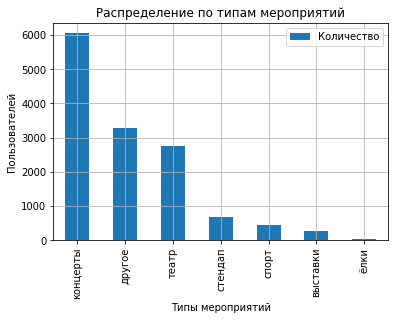

In [112]:
def count_percent_sum(df_local, groupby, count_col, head=10, ascending=False): # Таблица по количеству булевых значений.
    temp_df = pd.DataFrame({
        'Количество': df_local.groupby(by=groupby)[count_col].sum().sort_values(ascending=ascending),
        'Процент' : df_local.groupby(by=groupby)[count_col].sum().sort_values(ascending=ascending) * 100 / df_local[count_col].sum()
    }).head(head)
    display(temp_df.style.format({'Процент': '{:.2f}'}).background_gradient(cmap='coolwarm'))

def segment_bar_plot(df_local, groupby, count_col, head=10, ascending=False, title='Заголовок', xlabel='Ось X', ylabel='Ось Y'):
    temp_df = pd.DataFrame({
        'Количество': df_local.groupby(by=groupby)[count_col].sum().sort_values(ascending=ascending),
    }).head(head)
    temp_df.plot(
        kind='bar',
        rot=90,
        grid=True,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel
    )
count_percent_sum(df_profiles, 'event_type_first', 'is_two')
segment_bar_plot(df_profiles, 'event_type_first', 'is_two', xlabel='Типы мероприятий',
                 title='Распределение по типам мероприятий', ylabel='Пользователей')

По типу первого использованного длля покупки на платформе устройства

,Количество,Процент
device_first_order,,
mobile,11123,82.10
desktop,2425,17.90


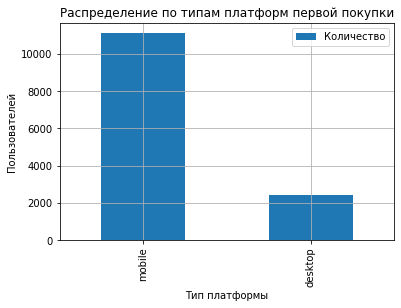

In [113]:
count_percent_sum(df_profiles, 'device_first_order', 'is_two')
segment_bar_plot(df_profiles, 'device_first_order', 'is_two', xlabel='Тип платформы',
                 title='Распределение по типам платформ первой покупки', ylabel='Пользователей')

По региону

,Количество,Процент
region_first_order,,
Каменевский регион,4531,33.44
Североярская область,2439,18.00
Широковская область,808,5.96
Озернинский край,375,2.77
Шанырский регион,351,2.59
Светополянский округ,311,2.30
Травяная область,306,2.26
Малиновоярский округ,303,2.24
Речиновская область,283,2.09


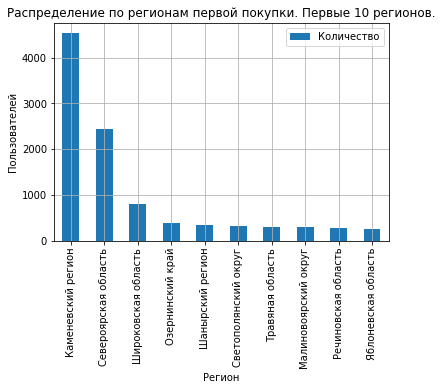

In [114]:
count_percent_sum(df_profiles, 'region_first_order', 'is_two')
segment_bar_plot(df_profiles, 'region_first_order', 'is_two', xlabel='Регион',
                 title='Распределение по регионам первой покупки. Первые 10 регионов.', ylabel='Пользователей')

По билетному оператору

,Количество,Процент
service_name_first,,
Билеты без проблем,3166,23.37
Мой билет,1856,13.70
Лови билет!,1761,13.00
Билеты в руки,1635,12.07
Облачко,1353,9.99
Весь в билетах,841,6.21
Лучшие билеты,728,5.37
Прачечная,373,2.75
Край билетов,303,2.24


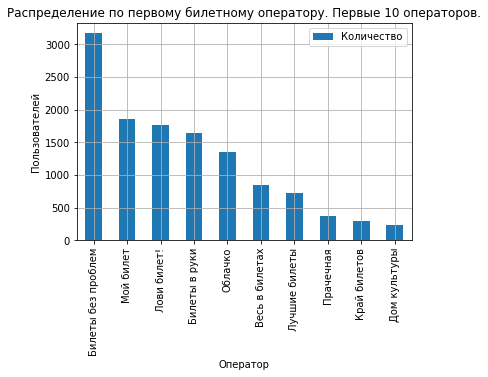

In [115]:
count_percent_sum(df_profiles, 'service_name_first', 'is_two')
segment_bar_plot(df_profiles, 'service_name_first', 'is_two', xlabel='Оператор',
                 title='Распределение по первому билетному оператору. Первые 10 операторов.', ylabel='Пользователей')

Статистика распределения по сегментам пользователей, совершивших два и более заказа практически совпадает со статистикой в целом по выборке. В лидерах те же типы мероприятий, тип устройства, регионы и билетные операторы, практически с тем же распределением.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**